In [1]:
get_ipython().magic('matplotlib inline')
import pandas;
import matplotlib;
import matplotlib.pyplot as plt
import scipy.io;
import numpy as np
from matplotlib.pylab import rcParams
import math
from scipy import signal
import scipy.stats

from scipy.stats import norm
from scipy.stats import describe
from sklearn.neighbors import KernelDensity

rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300;
rcParams['lines.linewidth'] = 2.2;
plt.style.use('fivethirtyeight');

In [2]:
get_ipython().magic('pdb')

Automatic pdb calling has been turned ON


In [3]:
def synthetic_neuron(drive):
    """
    Simulates a mock neuron with a time step of 1ms.
    Arguments:
    drive - input to the neuron (expect zero mean; SD=1)
    Returns:
    rho - response function (0=non-spike and 1=spike at each time step)
    """
    dt = .001
    T = dt*len(drive)
    time = np.arange(0, T, dt)
    lagSteps = .02/dt
    drive = np.concatenate((np.zeros(lagSteps), drive[lagSteps:])) 
    system = scipy.signal.lti([1], [.03**2, 2*.03, 1])
    _, L, _ = scipy.signal.lsim(system, drive[:,np.newaxis], time) 
    rate = np.divide(30, 1 + np.exp(50*(.05-L)))
    spikeProb = rate*dt
    return np.random.rand(len(spikeProb)) < spikeProb

def gaussian(x, mu, var):
    return np.exp(-np.power(x-mu, 2.)/(2*var))

def plot_spike_raster(trial, spikeTimes, ax):
    rep_trials = np.repeat(trial, np.size(spikeTimes))
    sizes = np.ones(len(spikeTimes))*60;
    ax.axhline(y=trial, linewidth=0.3);
    ax.scatter(spikeTimes, np.array([rep_trials]), marker='|', alpha=0.9,
               color='black', s=sizes);

def plot_psth(spikeTimes, num_bins, ax2, **kwargs):
#     counts = ax2.hist(spikeTimes, bins = num_bins, **kwargs);
    hist1, bin1 = np.histogram(spikeTimes, bins=num_bins)
    bincens = 0.5*(bin1[1:] + bin1[:-1])
    width = (bin1[1] - bin1[0]);
    ax2.bar(bincens, hist1, align='center', width=width, alpha=0.8);
    return (hist1, bincens);

def set_axis_range(series, func):
    minmax = scipy.stats.describe(series).minmax;
    func([math.floor(minmax[0]-minmax[0]/5), math.ceil(minmax[1]+minmax[1]/5)])

## 1a
Load the synthetic data file MT direction tuning. The file contains two
variables: “direction” is a list of stimulus directions for 200 trials.

In [4]:
tuning_data = scipy.io.loadmat('MT direction tuning.mat');

In [5]:
sptimes = 1000*tuning_data['spikeTimes'][0];
directions = tuning_data['direction'];
# print(directions.shape, sptimes.shape)
num_rows = np.array([x.shape[1] for x in sptimes]).sum();
df_cols = ['trial','direction', 'timestamp'];
sp_tr_list = [];
for j in range(0, directions.shape[1]):
    sp_tr = sptimes[j].T;
    direcn = directions[:, j];
    for k in range(0, sp_tr.shape[0]):
        sp = sp_tr[k,:];
        dict1 = {'trial': j+1, 'direction': direcn.tolist()[0], 
                 'timestamp': sp.tolist()[0]};
        sp_tr_list.append(dict1);
df = pandas.DataFrame(sp_tr_list, index=np.arange(0, num_rows), columns = df_cols);

## 1b 
Plot the spike raster and multi trial firing rate (5ms bins) for 0° trials.
Trial length is 2s.

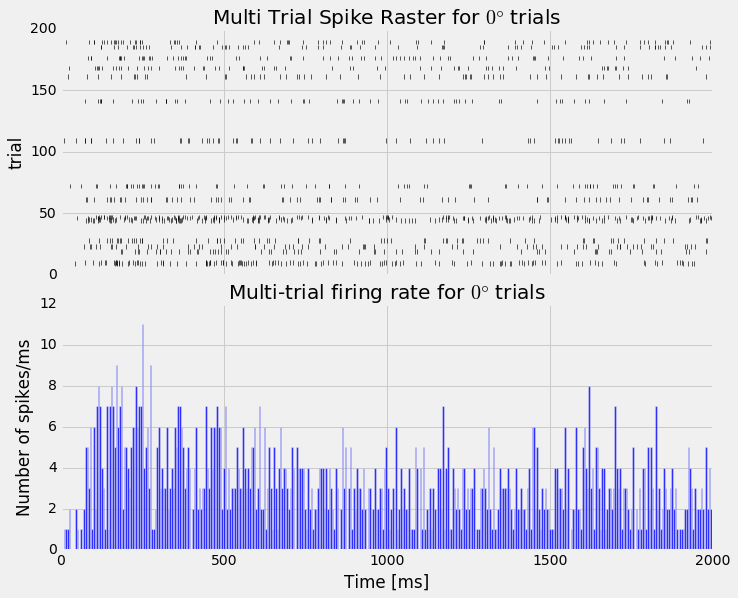

In [6]:
zrdf = df[df.direction==0]; zrdf.shape
f, ax = plt.subplots(2,1, sharex=True)
f.tight_layout();
ax[0].set_xlim([0,2000])
ax[0].set_ylim([0,200])
ax[0].set_title('Multi Trial Spike Raster for $0\degree$ trials')

dt = 5; #5ms sampling
trial_length = 2000; #ms
num_bins = trial_length/dt; #5 ms bins
num_samples = 200; 

t_plot = np.arange(0, 2005, dt);

zrdf.plot.scatter(ax=ax[0], x='timestamp', y='trial', marker='|', alpha=0.8,
                   s=np.ones(len(zrdf))*20, linewidth=.8, color='k');


# dont have to do any of the following stuff since the scaled counts is 
# equal to actual counts in this case (5ms sampling period)
# counts, binedges = np.histogram(zrdf['timestamp'], bins=int(num_bins));
# counts = 1000/(num_samples*trial_length)*counts; #convert to Hz
# print(counts)
# center = (binedges[:-1] + binedges[1:]) / 2;
# width = (binedges[1]-binedges[0]);
# ax[1].bar(center, counts, align='center', width=width);

plot_psth(zrdf['timestamp'].values, num_bins, ax[1], )

ax[1].set_ylabel('Number of spikes/ms');
ax[1].set_title('Multi-trial firing rate for $0\degree$ trials')
ax[1].set_xlabel('Time [ms]');
plt.show()

Use Gaussian window functions to generate single trial rate estimates

## 1c
Plot together the single trial rate estimate for trial 9 using a Gaussian
kernels with SD=5ms and SD=50ms. (Use an appropriate sampling period of your choice for which the rate fluctuations are not visibly distorted in the plot.)

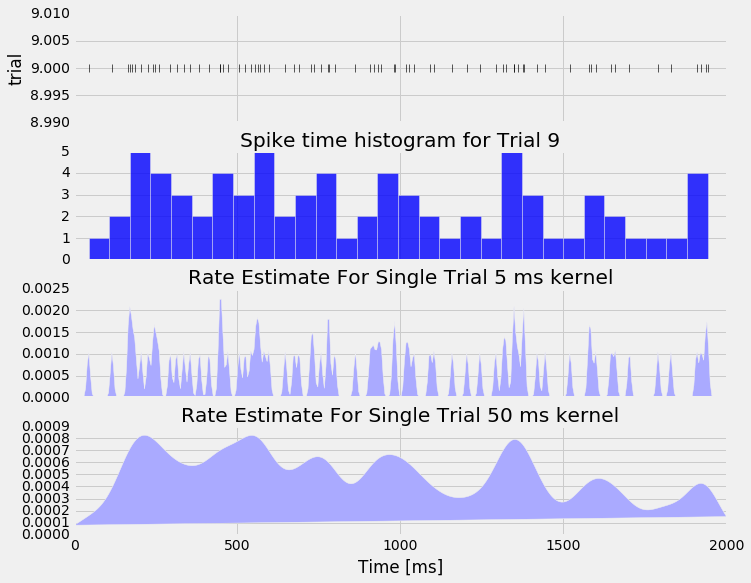

In [90]:
t9_df = df[df.trial == 9];

num_bins2 = 30
fig1, axx = plt.subplots(4,1, sharex=True)
fig1.tight_layout();
t9_df.plot(kind='scatter', ax=axx[0], x='timestamp', y = 'trial', marker='|', alpha=0.8,
                   s=np.ones(len(t9_df))*60, linewidth=.8, color='k')
# t9_df.timestamp.hist(ax=axx[1], bins = int(num_bins2), histtype='step');
plot_psth(t9_df.timestamp.values, num_bins2, axx[1]);
axx[1].set_title('Spike time histogram for Trial 9');


std_dev1 = 5; 
std_dev2 = 50; # in seconds
len_gauss = 5;


x_plot = np.linspace(0, 2000, num_bins)[:, np.newaxis]
x_fit = t9_df.timestamp.reshape(-1,1);

kde_1 = KernelDensity(kernel='gaussian', bandwidth=std_dev1).fit(x_fit);
smooth1 = np.exp(kde_1.score_samples(x_plot));
axx[2].fill(x_plot[:, 0], smooth1, fc='#AAAAFF')
axx[2].set_title('Rate Estimate For Single Trial 5 ms kernel');
axx[2].set_xlim([0, 2000])

kde_2 = KernelDensity(kernel='gaussian', bandwidth=std_dev2).fit(x_fit);
smooth2 = np.exp(kde_2.score_samples(x_plot));
axx[3].fill(x_plot[:, 0], smooth2, fc='#AAAAFF')
axx[3].set_title('Rate Estimate For Single Trial 50 ms kernel');
axx[3].set_xlim([0, 2000]);
axx[3].set_xlabel('Time [ms]');


plt.show()

## 1d
Plot the tuning curve with standard deviation error bars using data from 50 250ms. (Tip: use a library function to find unique direction values.)

If direction is represented by $s$, the tuning curve maybe found by plotting the following function,
$$f(s) = [r_0 +(r_{max} - r_0)cos(s−s_{max})]_+ $$, where $r_0$ is an offset, $r_{max}$ is the maximum response corresponding with a stimulus value $s_{max}$

In [81]:
all_directons = list(set(df.direction));
duration = 0.2; #in seconds from 50ms to 250ms
t_dict = [];
tuning_dat = [];       
for tr in set(df.trial):
    tr_df = df[df.trial == tr]; # all timestamps for trial
    tr_df_window = tr_df.query('timestamp >= 50.0 & timestamp <= 250.0'); 
    tr_spike_rate = tr_df_window.shape[0]/duration;
    tr_dict = {'direction': list(set(tr_df.direction))[0], 'rate': tr_spike_rate};
    t_dict.append(tr_dict);

t_df = pandas.DataFrame(t_dict, index=np.arange(0, len(t_dict)), columns = ['direction', 'rate']);
for each_dir in all_directons:
    curr_df = t_df[t_df.direction == each_dir];
    avg_rate = curr_df.rate.mean();
    err_bars = curr_df.rate.std();
    tuning_dat.append({'direction': each_dir, 'rate': avg_rate, 'err': err_bars});
tune_df = pandas.DataFrame(tuning_dat, index=np.arange(0, len(tuning_dat)), columns =['direction', 'rate', 'err']);
tune_df = tune_df.sort_values(['direction'])

(0, 360)

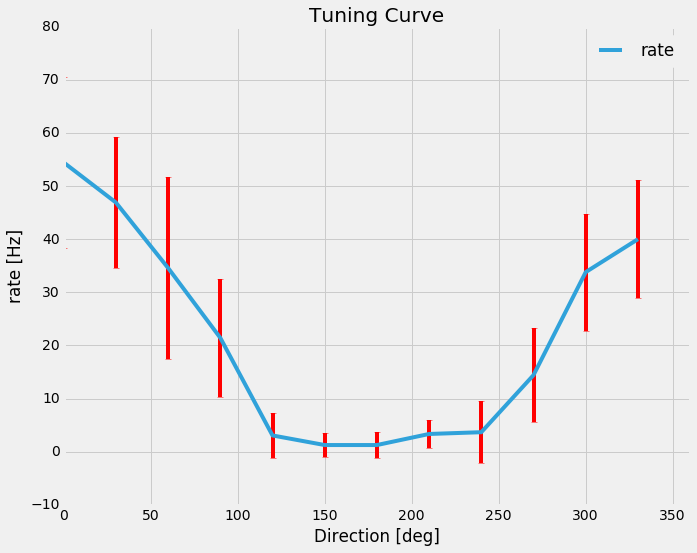

In [88]:
f,ax = plt.subplots();
# ax.plot(tune_df.direction, tune_df.rate)
tune_df.plot.line(ax = ax, x='direction', y='rate', yerr='err', ecolor='r')
ax.set_title('Tuning Curve');
ax.set_xlabel('Direction [deg]')
ax.set_ylabel('rate [Hz]')
ax.set_xlim([0, 360])

In [78]:
np.sqrt(describe(t_df.rate).variance)

21.359326985803186

## 1e
bSearch the electrophysiology literature to find a (real) tuning curve from a mouse. Include and explain a figure that shows the tuning curve.
![title](mouse_tuning.png)

The above figure, obtained from <http://www.jneurosci.org/content/28/30/7520.full>, titled Highly Selective Receptive Fields in Mouse Visual Cortex, shows orientation selectivity for primary visual cortex neurons for episodic stimuli of drifting bars at various orientations. The studied neuron exhibited a tendency to select for linearly oriented stimuli, as evident in the sub figure B, where the tuning curve peaks around 202 degrees


## Spike Triggered Averages
Load the c1p8 data file. This data is from Dayan & Abbott’s web site and
contains H1 neuron spike data collected by de Ruyter van Steveninck. There are two variables: “stim” is stimulus velocity, and “rho” is the response function (Δt=2ms).

In [89]:
# cpdat = scipy.io.loadmat('c1p8.mat');
print(cpdat['stim'].shape)
print(cpdat['rho'].shape)

(600000, 1)
(600000, 1)
